In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import tensorflow as tf  
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
import sklearn
import os
from PIL import Image
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# Define the base directories for training and validation data
train_dir = 'D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment2/Dataset/FaceExpression/images/train'
val_dir = 'D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment2/Dataset/FaceExpression/images/validation'

# Define a list of emotion categories
categories = ['sad', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'angry']

# Initialize empty lists to store the data
train_images = []
train_labels = []
val_images = []
val_labels = []

# Function to load images and their corresponding categories
def load_data(base_dir, data_images, data_labels):
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        category_label = categories.index(category)  # Label for the category
        
        for filename in os.listdir(category_dir):
            if filename.endswith('.jpg'):  # Assuming images are in JPG format
                img_path = os.path.join(category_dir, filename)
                img = Image.open(img_path)
                #img = img.resize((48, 48))  # You may adjust the image size as needed
                img = np.array(img) / 255.0  # Normalize pixel values to the range [0, 1]
                data_images.append(img)
                data_labels.append(category_label)

# Load training data
load_data(train_dir, train_images, train_labels)

# Load validation data
load_data(val_dir, val_images, val_labels)

# Convert data to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Verify the shapes of the data
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Training Images Shape: (28821, 48, 48)
Training Labels Shape: (28821,)
Validation Images Shape: (7066, 48, 48)
Validation Labels Shape: (7066,)


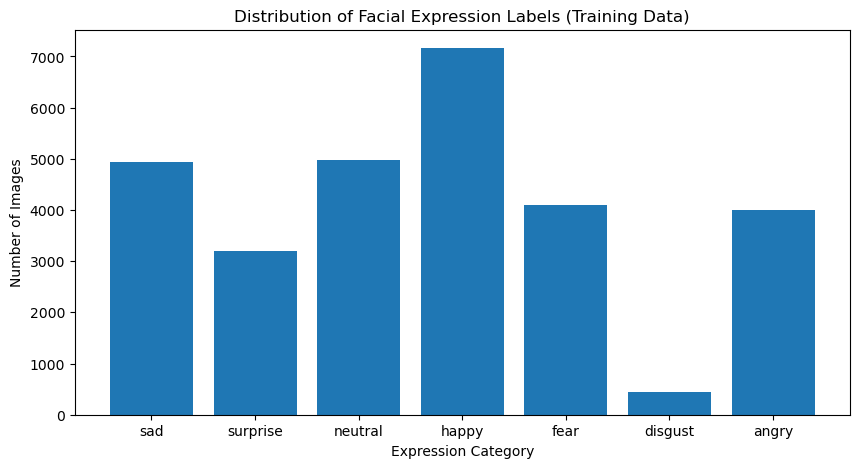

In [3]:
# Visualize the distribution of facial expression labels
expression_count = np.bincount(train_labels)
plt.figure(figsize=(10, 5))
plt.bar(categories, expression_count)
plt.title("Distribution of Facial Expression Labels (Training Data)")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.show()

In [4]:
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images.reshape(-1, 48 * 48), train_labels)

# Reshape the resampled data to the original shape
train_images_resampled = train_images_resampled.reshape(-1, 48, 48, 1)

# Verify the shapes of the resampled data
print("Resampled Training Images Shape:", train_images_resampled.shape)
print("Resampled Training Labels Shape:", train_labels_resampled.shape)


Resampled Training Images Shape: (50148, 48, 48, 1)
Resampled Training Labels Shape: (50148,)


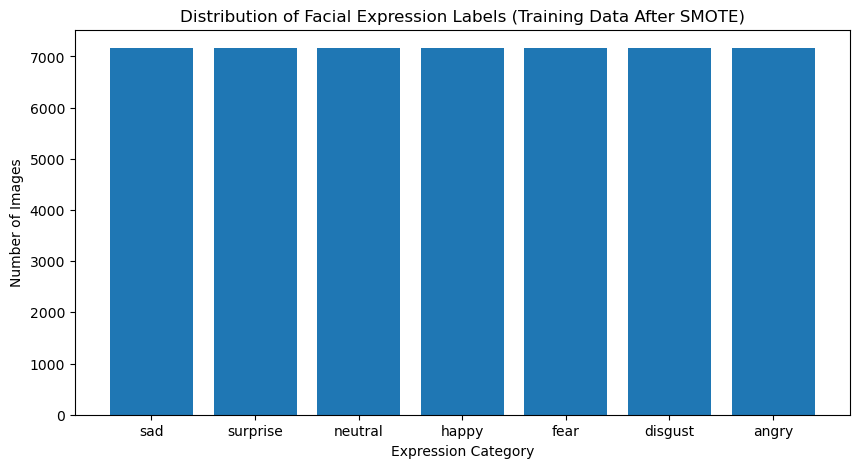

In [5]:
# Visualize the distribution of facial expression labels after oversampling
expression_count_resampled = np.bincount(train_labels_resampled)
plt.figure(figsize=(10, 5))
plt.bar(categories, expression_count_resampled)
plt.title("Distribution of Facial Expression Labels (Training Data After SMOTE)")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.show()

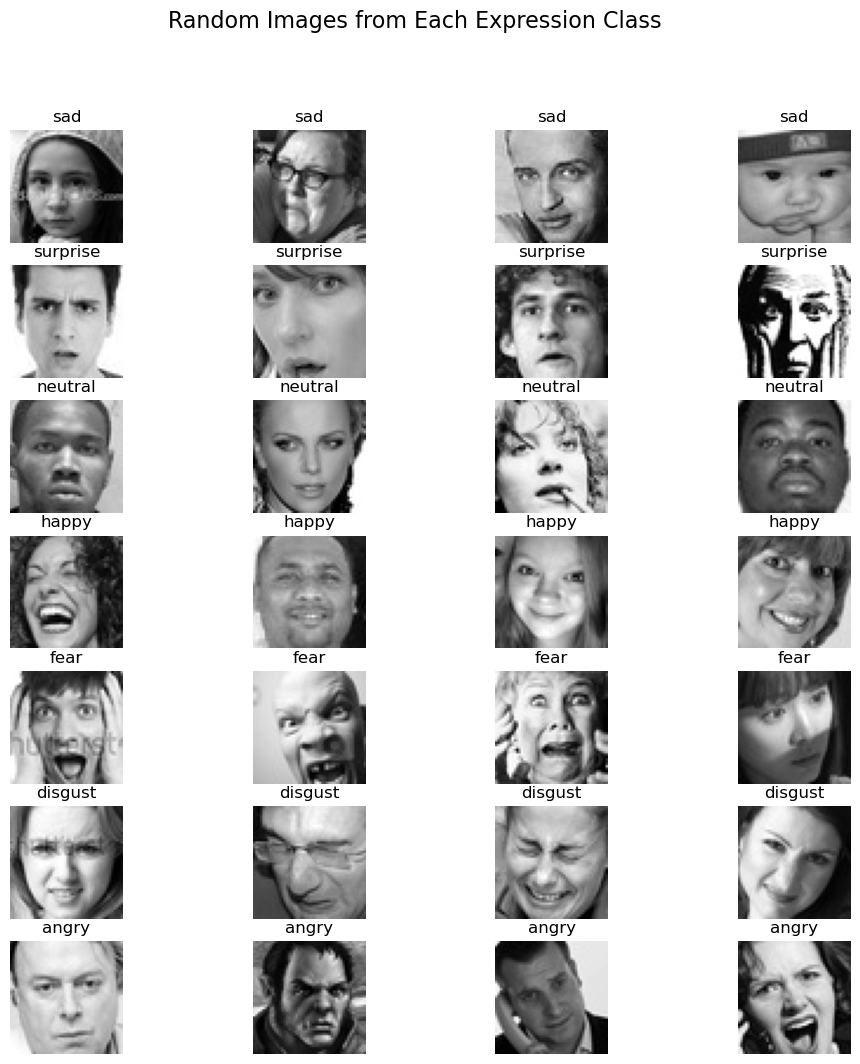

In [6]:
# Display 4 random images from each expression class
import random
num_samples_per_class = 4
plt.figure(figsize=(12, 12))

for i, category in enumerate(categories):
    category_indices = np.where(train_labels == i)[0]
    random_indices = random.sample(list(category_indices), num_samples_per_class)
    
    for j, idx in enumerate(random_indices):
        plt.subplot(len(categories), num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(train_images[idx], cmap='gray')
        plt.title(category)
        plt.axis('off')

plt.suptitle("Random Images from Each Expression Class", fontsize=16)
plt.show()

In [7]:
#Defined a call back function to stop training when accuracy reaches 98%
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:                 
                print("\nReached 98% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True
# Instantiate class
callback = myCallback()

In [8]:
# Convert labels to one-hot encoding
import keras
num_classes = len(categories)
train_labels = keras.utils.to_categorical(train_labels_resampled, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_cnn_model(num_filters=32, num_conv_layers=2, num_dense_layers=1, dense_units=128):
    # Create a Sequential model
    model = keras.Sequential()

    # Add convolutional layers
    for _ in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', input_shape=(48, 48, 1)))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from convolutional layers
    model.add(layers.Flatten())

    # Add dense layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu'))

    # Add the output layer with softmax activation for multiclass classification
    model.add(layers.Dense(7, activation='softmax'))  # Hardcoded 7 for the number of classes

    # Compile the model with appropriate loss and metrics
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_evaluate_cnn(num_filters=32, num_conv_layers=2, num_dense_layers=1, dense_units=128, epochs=100, batch_size=32):
    # Create the CNN model
    model = create_cnn_model(num_filters, num_conv_layers, num_dense_layers, dense_units)

    # Train the model
    history = model.fit(train_images_resampled, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels), callbacks=[callback])

    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate(val_images, val_labels)
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')

    # Test the model and calculate evaluation metrics
    y_pred = model.predict(val_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(np.argmax(val_labels, axis=1), y_pred_classes)
    precision = precision_score(np.argmax(val_labels, axis=1), y_pred_classes, average='macro')
    recall = recall_score(np.argmax(val_labels, axis=1), y_pred_classes, average='macro')
    f1 = f1_score(np.argmax(val_labels, axis=1), y_pred_classes, average='macro')

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

    return accuracy, precision, recall, f1, history, y_pred_classes


In [11]:
#Running Model 1: User Defined Parameters
#Without hyperparameter tuning

accuracy1, precision1, recall1, f1_1, history1, y_pred1 = train_evaluate_cnn(num_filters=32, num_conv_layers=2, num_dense_layers=2, dense_units=128, epochs=50, batch_size=32)


Epoch 1/50
1568/1568 [==============================] - 35s 22ms/step - loss: 1.4625 - accuracy: 0.4313 - val_loss: 1.4532 - val_accuracy: 0.4295
Epoch 2/50
1568/1568 [==============================] - 34s 22ms/step - loss: 1.0912 - accuracy: 0.5823 - val_loss: 1.3985 - val_accuracy: 0.4909
Epoch 3/50
1568/1568 [==============================] - 35s 22ms/step - loss: 0.9353 - accuracy: 0.6454 - val_loss: 1.3570 - val_accuracy: 0.5167
Epoch 4/50
1568/1568 [==============================] - 35s 23ms/step - loss: 0.8136 - accuracy: 0.6975 - val_loss: 1.3992 - val_accuracy: 0.5184
Epoch 5/50
1568/1568 [==============================] - 35s 23ms/step - loss: 0.6935 - accuracy: 0.7472 - val_loss: 1.5242 - val_accuracy: 0.5082
Epoch 6/50
1568/1568 [==============================] - 35s 22ms/step - loss: 0.5943 - accuracy: 0.7883 - val_loss: 1.5554 - val_accuracy: 0.5146
Epoch 7/50
1568/1568 [==============================] - 35s 22ms/step - loss: 0.5005 - accuracy: 0.8240 - val_loss: 1.8578 -

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Define the hyperparameter grid for the CNN model
param_grid = {
    'num_filters': [64, 128],
    'num_conv_layers': [ 3, 4],
    'num_dense_layers': [2, 3],
    'dense_units': [64, 128],
    'epochs': [20, 50],
    'batch_size': [32, 64]
}

# Create a KerasClassifier with the CNN model and fixed input shape
cnn_classifier = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Initialize GridSearchCV with the CNN model as the estimator
grid_search = GridSearchCV(estimator=cnn_classifier,
                           param_grid=param_grid,
                           scoring=make_scorer(accuracy_score),
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Fit the GridSearchCV object
grid_search.fit(train_images_resampled, train_labels)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_params}')

Best parameters: {'num_filters': 128, 'num_conv_layers': 4, 'num_dense_layers': 3, 'dense_units': 128, 'epochs': 50, 'batch_size': 64}


In [14]:
#running test for the model with the best parameters
accuracy2, precision2, recall2, f1_2, history2, y_pred2 = train_evaluate_cnn(**best_params)



Epoch 1/50
784/784 [==============================] - 154s 196ms/step - loss: 1.6407 - accuracy: 0.3395 - val_loss: 1.3773 - val_accuracy: 0.4625
Epoch 2/50
784/784 [==============================] - 152s 194ms/step - loss: 1.2060 - accuracy: 0.5306 - val_loss: 1.3009 - val_accuracy: 0.4972
Epoch 3/50
784/784 [==============================] - 153s 195ms/step - loss: 1.0409 - accuracy: 0.5953 - val_loss: 1.2821 - val_accuracy: 0.5112
Epoch 4/50
784/784 [==============================] - 149s 190ms/step - loss: 0.9357 - accuracy: 0.6421 - val_loss: 1.2432 - val_accuracy: 0.5471
Epoch 5/50
784/784 [==============================] - 149s 190ms/step - loss: 0.8523 - accuracy: 0.6749 - val_loss: 1.2764 - val_accuracy: 0.5552
Epoch 6/50
784/784 [==============================] - 148s 189ms/step - loss: 0.7794 - accuracy: 0.7065 - val_loss: 1.3014 - val_accuracy: 0.5385
Epoch 7/50
784/784 [==============================] - 149s 190ms/step - loss: 0.7130 - accuracy: 0.7353 - val_loss: 1.3108 -